In [ ]:
import kagglehub

In [ ]:
path = kagglehub.dataset_download("sriramr/fruits-fresh-and-rotten-for-classification")

100%|██████████| 3.58G/3.58G [00:39<00:00, 97.6MB/s]

Extracting files...


In [ ]:
import tensorflow as tf
import os
train_path = os.path.join(path,'dataset','train')

In [ ]:
img_height = 224
img_width = 224
batch_size = 32

In [ ]:
validation_split = 0.2
seed = 123

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 10901 files belonging to 6 classes.
Using 8721 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 10901 files belonging to 6 classes.
Using 2180 files for validation.


In [ ]:
original_class_name_for_display = train_ds.class_names

In [ ]:
original_class_name_for_display

['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

### **Normalization**

In [ ]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(normalize_img, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
val_ds = val_ds.map(normalize_img, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def binary_map_labels(image, label):
    # Labels 0, 1, 2 correspond to 'fresh' fruits (freshapples, freshbanana, freshoranges)
    # Labels 3, 4, 5 correspond to 'rotten' fruits (rottenapples, rottenbanana, rottenoranges)
    # We want to map 'fresh' to 0 and 'rotten' to 1
    binary_label = tf.where(label < 3, 0, 1)
    return image, binary_label

In [ ]:
train_ds = train_ds.map(binary_map_labels, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(binary_map_labels, num_parallel_calls=AUTOTUNE)

## DATA **AUGMENTATION**

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


This CNN model includes data augmentation as its first layer, followed by three convolutional blocks (Conv2D + MaxPooling2D) to extract features. A `Flatten` layer converts the 2D feature maps into a 1D vector, and two `Dense` layers (a hidden layer and an output layer) perform the classification. The final `Dense` layer uses a sigmoid activation for binary classification, outputting a probability between 0 and 1.

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
epochs = 20
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 127s 434ms/step - accuracy: 0.6983 - loss: 0.6393 - val_accuracy: 0.9005 - val_loss: 0.2367
Epoch 2/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 83s 301ms/step - accuracy: 0.9059 - loss: 0.2380 - val_accuracy: 0.9349 - val_loss: 0.1807
Epoch 3/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 80s 293ms/step - accuracy: 0.9163 - loss: 0.2088 - val_accuracy: 0.9367 - val_loss: 0.1515
Epoch 4/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 78s 283ms/step - accuracy: 0.9373 - loss: 0.1637 - val_accuracy: 0.9468 - val_loss: 0.1314
Epoch 5/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 78s 284ms/step - accuracy: 0.9387 - loss: 0.1576 - val_accuracy: 0.9165 - val_loss: 0.2018
Epoch 6/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 77s 282ms/step - accuracy: 0.9421 - loss: 0.1470 - val_accuracy: 0.9537 - val_loss: 0.1105
Epoch 7/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 80s 290ms/step - accuracy: 0.9474 - loss: 0.1292 - val_accuracy: 0.9601 - val_loss: 0.0986
Epoch 8/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 82s 300ms/step - accuracy: 0.9484 - loss: 

In [ ]:
test_path = os.path.join(path,'dataset','test')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2698 files belonging to 6 classes.


In [ ]:
test_ds = test_ds.map(normalize_img, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(binary_map_labels, num_parallel_calls=AUTOTUNE)

The `test_ds` has been normalized and its labels have been binary mapped, consistent with the preprocessing applied to the training and validation sets. **Note:** Data augmentation is intentionally *not* applied to the test dataset, as its purpose is to evaluate the model's performance on unseen, un-augmented data.

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 0.9860 - loss: 0.0469
Test Loss: 0.0509
Test Accuracy: 0.9844


In [ ]:
# Save the entire model in H5 format
model.save("fruits_classifier.h5")
from google.colab import files
files.download("fruits_classifier.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save the entire model in Keras native format (TensorFlow SavedModel format)
model.save('fruits_classifier.keras')
print("Model saved in native Keras format (folder 'fruits_classifier_keras_format')")
files.download('fruits_classifier.keras')

Model saved in native Keras format (folder 'fruits_classifier_keras_format')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


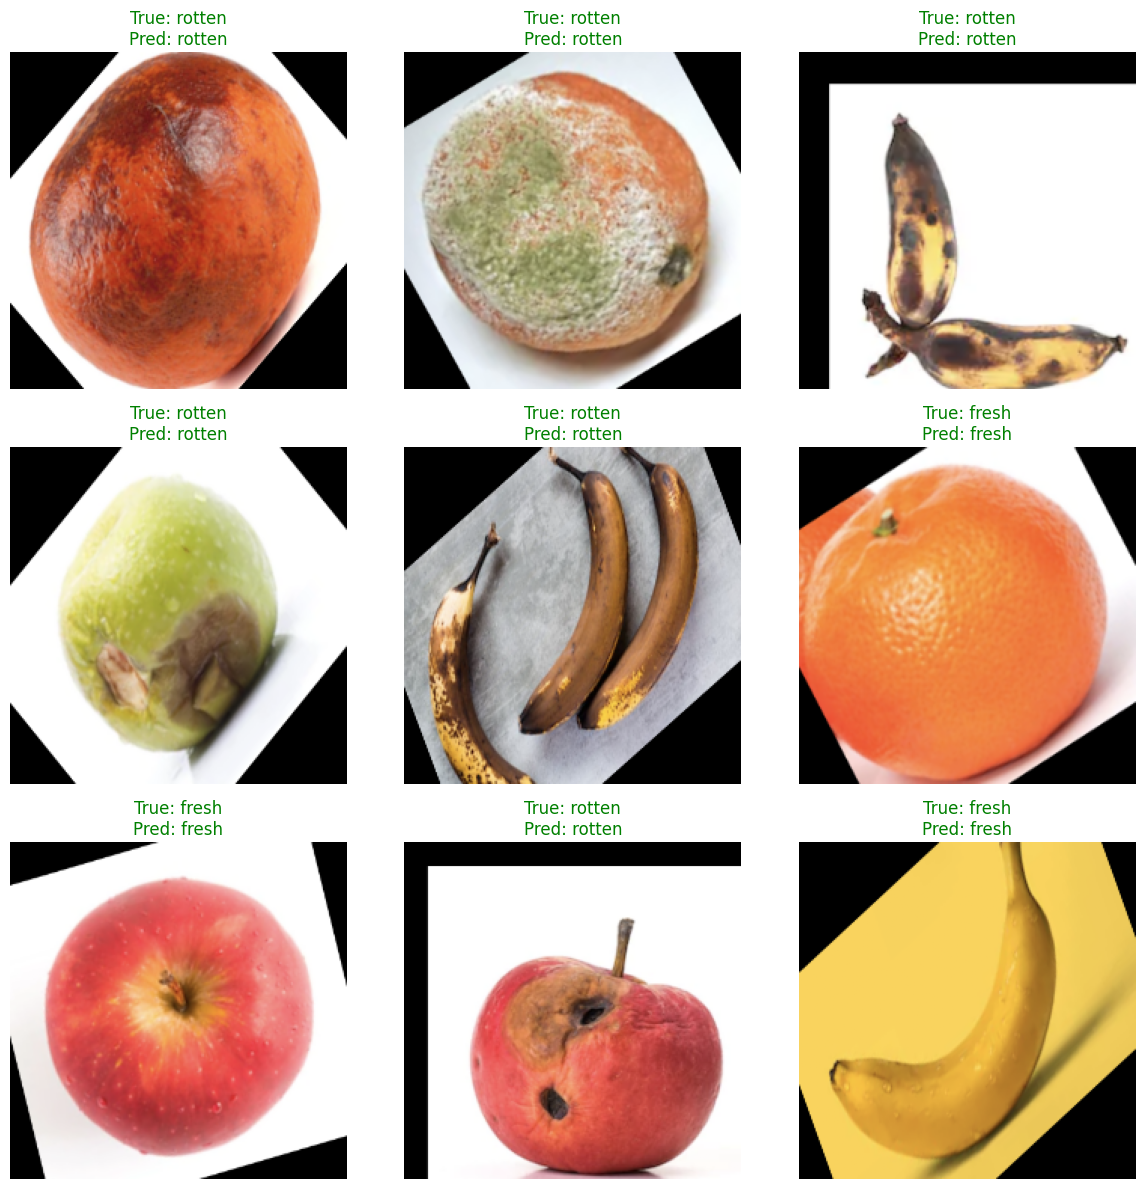

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of images and labels from the test dataset
for images, labels in test_ds.take(1):
    break

# Make predictions
predictions = model.predict(images)

# Convert probabilities to binary classes (0 or 1)
binary_predictions = np.round(predictions).flatten().astype(int)

# Define class names for display
class_names_map = {0: 'fresh', 1: 'rotten'}

plt.figure(figsize=(12, 12))
for i in range(min(len(images), 9)): # Display up to 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())

    true_label_text = class_names_map[labels[i].numpy()]
    predicted_label_text = class_names_map[binary_predictions[i]]

    color = "green" if true_label_text == predicted_label_text else "red"
    plt.title(f"True: {true_label_text}\nPred: {predicted_label_text}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()